# experiment results

This is the notebook which plots the results of the experiments. The script for running the experiments can be found in `scripts/runexperiments.py`, which puts results in nested dictionaries and saves it to a pickle file.

The majority of these experiments focus on isolating a single effect on the cross-correlation power spectrum. Unless otherwise specified, this cross-correlation is between the DM of $n = 2000$ FRBs from $0.3 < z < 0.4$ and the foreground galaxy overdensity with $0.2 < z_g < 0.3$. The DM units are $\text{pc}\,\text{cm}^{-3}$.

There are two setups that are commonly used as a base on top of which the effect is isolated:
- `fid`: The fiducial setup is motivated by the results of a [CHIME FRB populations paper](https://arxiv.org/pdf/2207.14316) which finds results consistent with FRBs tracing the star-formation rate of galaxies. It puts FRBs in star-forming galaxies; that is, it puts FRBs in galaxies by drawing host galaxies from $0.3 < z < 0.4$ with weight
$$ W(g_\text{host}) = \frac{\text{SFR}(g_\text{host})}{1+z(g_\text{host})}.$$ 
- A similar setup assumes that FRBs are uncorrelated with star formation, using the galaxy mass as weight:
$$ W(g_\text{host}) = \frac{M(g_\text{host})}{1+z(g_\text{host})}.$$
- `midslice`: Finally, we have FRBs distributed uniformly, one FRB per pixel, at the middle of the FRB redshift slice ($0.3 < z < 0.4$). This can be understood as the reference or "unbiased" power spectrum. 

These experiments are ran on 48 independent square sky regions. Each of these sky regions has a length of 0.1 rad, 125 pixels per side for a pixel size of 0.0008 rad. These sky regions were picked in order to avoid crossings in the periodic simulation box. For more details, see `notebooks/get_good_pixels.ipynb`. The majority of experiments involve drawing $n$ host galaxies; each sky region will have $n_\text{trials}=5$ independent draws for a total of $48 \times 5 = 240$ realizations. The setups which involve putting one FRB per pixel will have $48$ independent realizations.

All plots show the median and 68% credible intervals for different realizations of the power spectrum.

In [1]:
import numpy as np
import _pickle as pickle
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from scipy.stats import binned_statistic

In [2]:
import sys
sys.path.append('/home/submit/aqc/frb_project')
from illustris_frb import simulation, exp_simulation
from illustris_frb.regions import regions

sim = simulation()

frb_zrange = (0.3, 0.4)
frb_mean_x = np.mean(sim.comoving_distance(frb_zrange))
frb_mean_z = sim.z_from_dist(frb_mean_x)
print(frb_mean_z)

0.3492729716291206


In [3]:
# load in results

res_path = '/ceph/submit/data/group/submit-illustris/april/data/C_ells/trial_experiments.pkl'
with open(res_path, 'rb') as f:
    res = pickle.load(f)
print(list(res.keys()))

['regions', 'N_gs', 'host_properties', 'midslice', 'l', 'trial_DM_fields', 'fullz_FRB_properties', 'n_frbs_sfrweight', 'n_frbs_massweight', 'n_frbs_randpixels', 'n_frbs_injhostDM', 'DM_sfunc', 'DM_sfunc_injhostDM', 'DM_cutoffs', 'DM_cutoffs_injhostDM', 'm_g_cutoffs', 'proj_sfrweight_ClDgs', 'scatter_ClDgs', 'overlap_frb_zranges']


In [4]:
ells = res['l']

midslice_ClDgs = res['midslice']['ClDg']
midslice_DeltaCs = res['midslice']['DeltaCs']

n_frbs = 2000
fid_ClDgs = res['n_frbs_sfrweight'][n_frbs]

### plotting helper functions

In [5]:
figpath = '/ceph/submit/data/group/submit-illustris/april/data/figures'

In [6]:
colorcycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

magma = sns.color_palette("magma_r")
colorblind = sns.color_palette('colorblind')
mako = sns.color_palette("mako_r", 4)
flare = sns.color_palette("flare", 4)

plt.style.use({
    'font.family':        'serif',
    'font.serif':         ['DejaVu Sans'],
    'mathtext.fontset':   'stixsans',
    'figure.figsize':     (6,4),
    'legend.fontsize':    11,
    'legend.framealpha':  0.5,
    'lines.markersize':   1.5,
    'text.usetex':        False,
    'figure.dpi':         120,
    'savefig.dpi':        250,
    'savefig.bbox':       'tight',
    'savefig.pad_inches': 0.1,
    'axes.prop_cycle':    plt.cycler('color', colorcycle)
})

In [7]:
default_xlim = (100, 4000)
default_lin_ylim = (-0.0005, 0.004)
default_lin_yticks = (0, 0.001, 0.002, 0.003, 0.004)
default_log_ylim = (1e-7, 6e-3)

In [8]:
# cross-correlation power spectrum plotting functions

def plot_xcorr(ells, C_ls, ax=None, label=None, color='k', lw=1, 
               xlim=None, ylim=None, yticks=None, DeltaCs=None, xlabel=r'$\ell$',
               ylabel=r'$C_{\ell}^{Dg}$', alpha=1, xscale='log', yscale='linear', **kwargs):

    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(ells, C_ls, lw=lw, color=color, alpha=alpha, **kwargs)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    if xlim is None:
        # ax.set_xlim((ells[0], ells[-1]))
        ax.set_xlim(default_xlim)
    else:
        ax.set_xlim(xlim)
    
    if ylim is None:
        if yscale == 'log':
            ax.set_ylim(default_log_ylim)
        elif yscale == 'linear':
            ax.set_ylim(default_lin_ylim)
            ax.set_yticks(default_lin_yticks)
    else:
        ax.set_ylim(ylim)
        ax.set_yticks(yticks)

    if DeltaCs is not None:
        if len(DeltaCs)==2:
            ax.fill_between(ells, DeltaCs[0], DeltaCs[1], label=label, color=color, alpha=alpha*0.3)
        else:
            ax.fill_between(ells, C_ls-DeltaCs, C_ls+DeltaCs, label=label, color=color, alpha=alpha*0.3)

def plot_xcorr_trials(ells, C_l_list, ax=None, plotinterval=True, **kwargs):
    C_l_arr = np.vstack(C_l_list)
    if ax is None:
        fig, ax = plt.subplots()
    if plotinterval:
        interval = (np.percentile(C_l_arr, 16, axis=0), np.percentile(C_l_arr, 84, axis=0))
        plot_xcorr(ells, np.median(C_l_arr, axis=0), ax=ax, DeltaCs=interval, **kwargs)
    else:
        plot_xcorr(ells, np.mean(C_l_arr, axis=0), ax=ax, DeltaCs=np.std(C_l_arr, axis=0), **kwargs)

def plot_ref_ClDg(ax, ref_ClDg=midslice_ClDgs, lw1=0.7, lw2=0.5, color=None, label='default'):
    if label == 'default':
        if ref_ClDg is midslice_ClDgs:
            label = f'Mid-slice FRBs, z = {frb_mean_z:.2f}'
        elif ref_ClDg is fid_ClDgs:
            label = f'Fiducial'
    if color is None:
        if ref_ClDg is fid_ClDgs:
            color = magma[3]
        else:
            color='k'
    if lw1 > 0:
        ax.plot(ells, np.median(ref_ClDg, axis=0), color=color, lw=lw1, ls='--', label=label)
        label2=None
    else:
        label2=label
    if lw2 > 0:
        ax.plot(ells, np.percentile(ref_ClDg, 16, axis=0), color=color, lw=lw2, ls='--', label=label2)
        ax.plot(ells, np.percentile(ref_ClDg, 84, axis=0), color=color, lw=lw2, ls='--')

def subplot_from_list(results_list, ref_ClDg=None, ref_label='default', ref_lws=(1.2, 0.8), labels=None, 
                      ax=None, colors=colorcycle, legend=True, alpha=0.9, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.axhline(0, color='gray', ls='dotted', lw=0.8)
    if ref_ClDg is not None:
        plot_ref_ClDg(ax, ref_ClDg, lw1=ref_lws[0], lw2=ref_lws[1], label=ref_label)
    for i, result in enumerate(results_list):
        plot_xcorr_trials(ells, result, ax=ax, label=labels[i], color=colors[i], alpha=alpha, **kwargs)
    if legend:
        ax.legend()

# plot a dictionary of ClDg arrays
def subplot_from_dict(results_dict, whichkeys=None, ref_ClDg=None, ref_label='default', ref_lws=(1.2,0.8),
                     labels=None, ax=None, colors=colorcycle, legend=True, alpha=0.9, **kwargs):
    if whichkeys is None:
        whichkeys = list(results_dict.keys()) # which keys to plot
    else:
        whichkeys = [key for key in whichkeys if key in results_dict.keys()]
    if callable(labels):
        labels_ = [labels(key) for key in whichkeys]
    elif labels is None: # if no labels are given, default to dict keys
        labels_ = whichkeys
    else:
        labels_ = labels
    results_list = [results_dict[key] for key in whichkeys]
    subplot_from_list(results_list, ref_ClDg, ref_label, ref_lws, labels_, ax, colors, legend, alpha, **kwargs)

# plot a list of dictionaries of ClDg arrays, one dictionary per subplot
def generate_plots(results_dict_list, titles=None, figsize=None, whichkeys=None, ref_ClDg=None,
                   labels=None, colors=colorcycle, ylim=None, **kwargs):
    n = len(results_dict_list)
    if figsize is None:
        if n==2:
            figsize = (9,4)
        if n==3:
            figsize = (13,4)
    fig, axes = plt.subplots(1, n, figsize=figsize, sharex=True, sharey=True)
    for i, results_dict in enumerate(results_dict_list):
        subplot_from_dict(results_dict, whichkeys=whichkeys, ref_ClDg=ref_ClDg, 
                         labels=labels, ax=axes[i], colors=colors, **kwargs)
        if titles is not None:
            axes[i].set_title(titles[i])
    if ylim is not None:
        axes[0].set_ylim(ylim)
    for ax in axes[1:]:
        ax.set_ylabel('')
        
    plt.tight_layout()
    return fig, axes

In [10]:
midslice_DMs = np.concatenate(res['midslice']['DMs'], axis=None)
sfr_DMs, sfr_mults = np.concatenate(res['trial_DM_fields']['DM_fid'], axis=None), np.concatenate(res['trial_DM_fields']['mult_fid'], axis=None)
mass_DMs, mass_mults = np.concatenate(res['trial_DM_fields']['DM_mass'], axis=None), np.concatenate(res['trial_DM_fields']['mult_mass'], axis=None)

## DM distribution

We want to see if the DM distribution changes significantly if we put FRBs in galaxies ($0.3 < z < 0.4$) vs at a uniform redshift ($z = 0.35$). For each region, 2000 galaxies are drawn and ray-traced in the former case; in the latter case, one FRB is put in each grid for a total of $125^2$ FRB DMs per region.

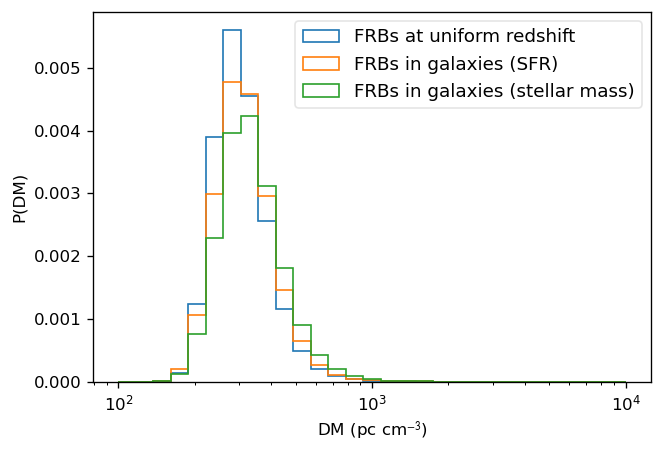

In [10]:
bins = np.logspace(2, 4, 30)
_ = plt.hist(midslice_DMs, bins=bins, density=True, label=f'FRBs at uniform redshift', histtype='step')
_ = plt.hist(sfr_DMs, bins=bins, weights=sfr_mults, density=True, label=f'FRBs in galaxies (SFR)', histtype='step')
_ = plt.hist(mass_DMs, bins=bins, weights=mass_mults, density=True, label=f'FRBs in galaxies (stellar mass)', histtype='step')

plt.xlabel('DM (pc cm$^{-3}$)')
plt.ylabel('P(DM)')
plt.legend()
plt.xscale('log')

plt.savefig(os.path.join(figpath, 'DM_hist.pdf'))

For each region, we also draw 2000 FRBs from galaxies (weighted by the SFR of the galaxy) from the full cone ($0 < z < 0.4$).

In [11]:
# DM vs x, properties of full cone up to z=0.4

DMs, xs = np.concatenate(res['fullz_FRB_properties']['DM'], axis=None), np.concatenate(res['fullz_FRB_properties']['x'], axis=None)
zs = sim.z_from_dist(xs)

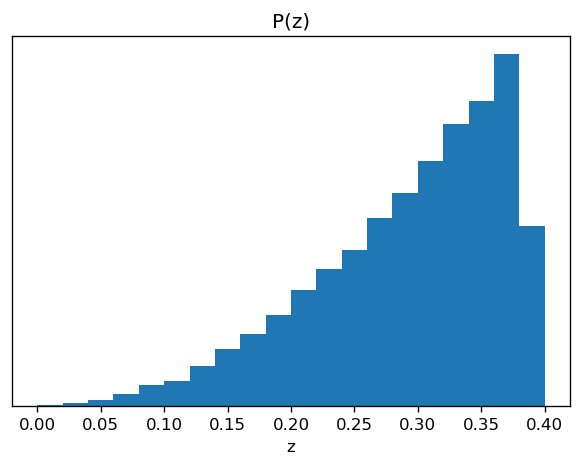

In [12]:
# P(z)

zbins = np.linspace(0, 0.4, 21)
_ = plt.hist(zs, bins=zbins)

plt.xlabel('z')
plt.yticks([])
plt.title('P(z)')

plt.savefig(os.path.join(figpath, 'fullcone_P_z.pdf'))

This is as expected; SFR does not change significantly at low redshifts, so this just scales with the volume. Here, we don't have a fluence cutoff, and hence no falloff at higher redshifts.

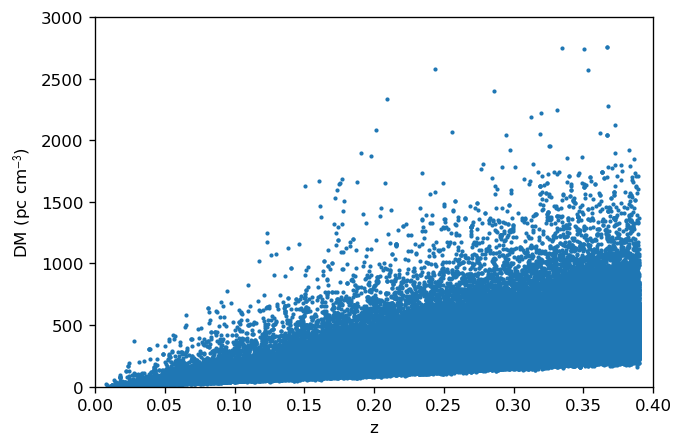

In [13]:
#DM vs z

plt.scatter(zs, DMs)
plt.xlabel('z')
plt.ylabel('DM (pc cm$^{-3}$)')
plt.xlim(0, 0.4)
plt.ylim(0, 3000)

plt.savefig(os.path.join(figpath, 'fullcone_DM_vs_z.pdf'))

(0.0, 511.44164516513723)

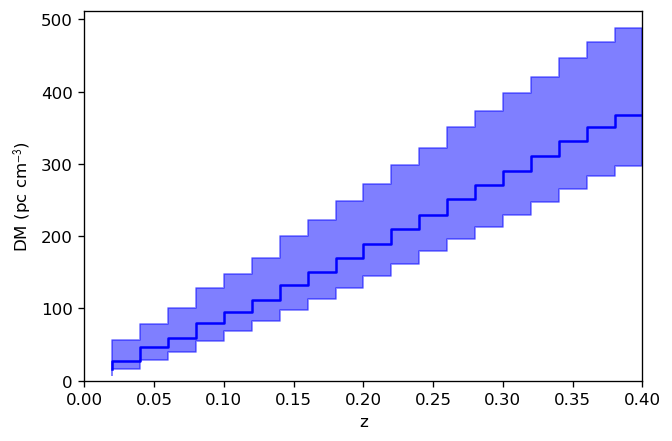

In [14]:
# divide into bins

DM_mid, _, _ = binned_statistic(zs, DMs, statistic='median', bins=zbins)
DM_low, _, _ = binned_statistic(zs, DMs, statistic=lambda x: np.percentile(x, 16), bins=zbins)
DM_high, _, _ = binned_statistic(zs, DMs, statistic=lambda x: np.percentile(x, 84), bins=zbins)

fig, ax = plt.subplots()
ax.step(zbins[1:], DM_mid, where='pre', color='b')
ax.fill_between(zbins[1:], DM_low, DM_high, alpha=0.5, step='pre', color='b')

ax.set_xlabel('z')
ax.set_ylabel('DM (pc cm$^{-3}$)')
ax.set_xlim(0, 0.4)
ax.set_ylim(bottom=0)

How does this compare with actual FRB measurements? I suspect the variance is lower because there is effectively no contribution to the variance from the host galaxy (poor resolution).

## non-Gaussianities

We compare the theoretical Gaussian error bar of the uniform-redshift power spectrum with its actual cosmic variance given by the 48 different sky regions. Unlike the other plots, we are plotting the mean (rather than the median) cross power-spectrum. 

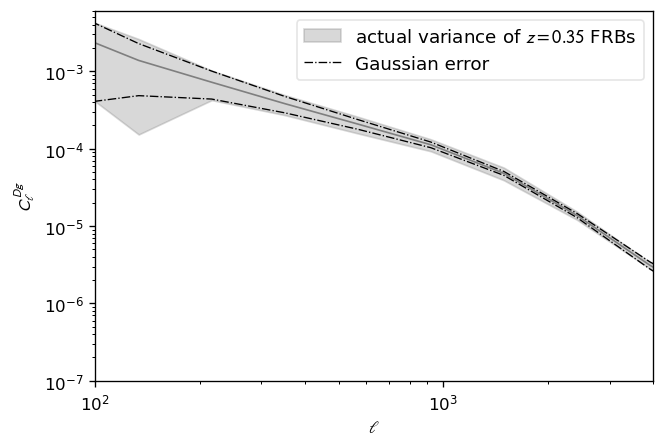

In [15]:
mean_DeltaC = np.mean(midslice_DeltaCs, axis=0)
mean_midslice_ClDg = np.mean(midslice_ClDgs, axis=0)

fig, ax = plt.subplots()
plot_xcorr_trials(ells, midslice_ClDgs, ax=ax, color=colorcycle[-3], plotinterval=False, yscale='log',label=f'actual variance of $z={frb_mean_z:.2f}$ FRBs')
ax.plot(ells, mean_midslice_ClDg-mean_DeltaC, color='k', ls='dashdot', lw=0.8, label='Gaussian error')
ax.plot(ells, mean_midslice_ClDg+mean_DeltaC, color='k', ls='dashdot', lw=0.8)
ax.legend()

plt.savefig(os.path.join(figpath, 'non_gaussianities_midslice.pdf'))

This result is difficult to interpret, with spectral leakage at small $\ell$ (finite sky region) and large $\ell$ (pixel resolution). Note that this shows the mean and standard deviation (as opposed to the median and 68% credible intervals, as is in all subsequent plots).

## number of FRBs

Power spectrum as a function of the number of FRBs ($n$) drawn in a sky region. 
- Left: $n$ FRBs drawn from galaxies weighted by the galaxy SFR (fiducial)
- Middle: $n$ FRBs draw from galaxies weighted by the galaxy stellar mass.
- Right: the cross-correlation was computed from a subset of $n$ pixels of the midslice DM grid, done by scrambling the FRB locations of the fiducial FRBs (left)

The dotted line shows the reference (midslice, one FRB in every pixel) power spectrum.

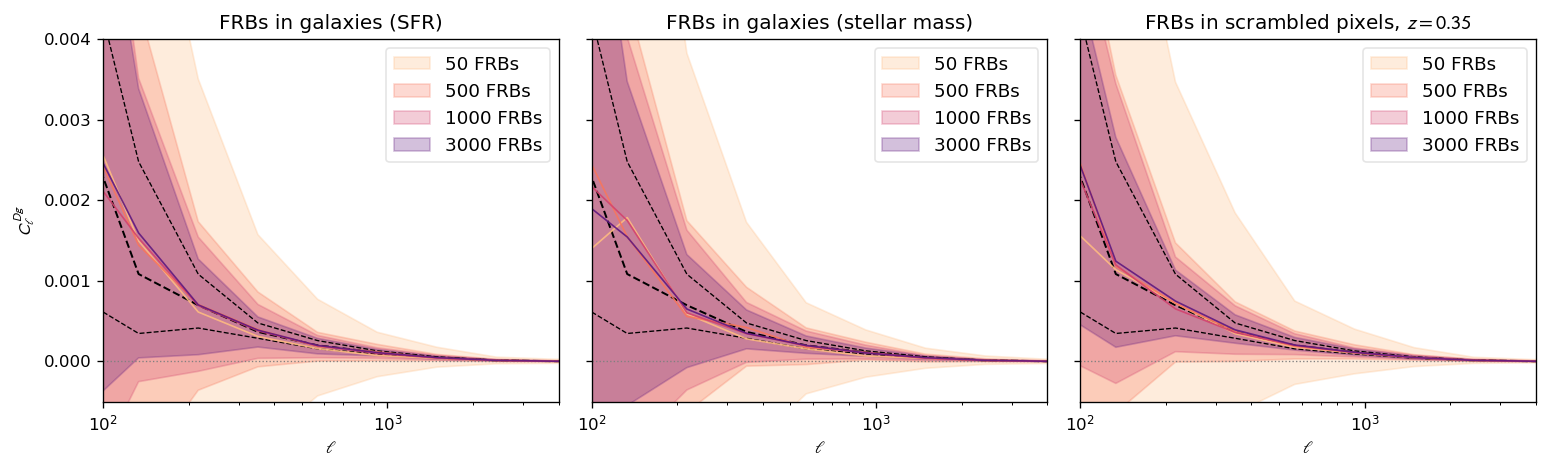

In [16]:
_ = generate_plots((res['n_frbs_sfrweight'],res['n_frbs_massweight'], res['n_frbs_randpixels']), 
                   titles=('FRBs in galaxies (SFR)', 'FRBs in galaxies (stellar mass)', f'FRBs in scrambled pixels, $z={frb_mean_z:.2f}$'),
                   whichkeys=(50, 500, 1000, 3000), ref_ClDg=midslice_ClDgs, ref_label=None, labels=lambda x: f'{x} FRBs',
                   plotinterval=True, colors=magma[:3]+magma[4:])
plt.savefig(os.path.join(figpath, 'n_frbs.pdf'))

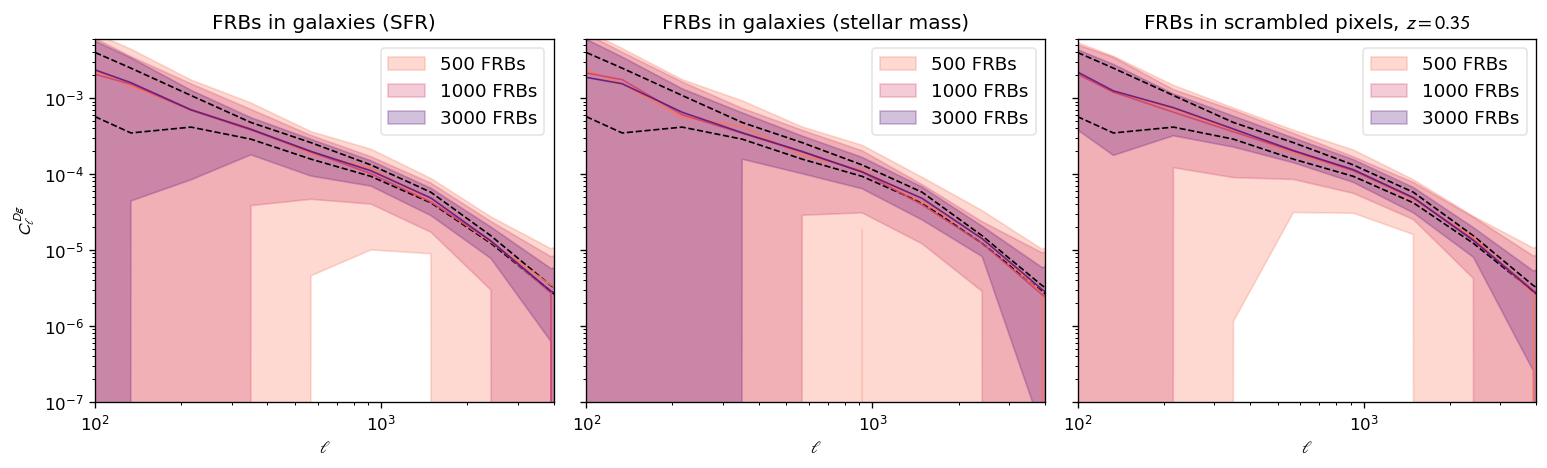

In [17]:
_ = generate_plots((res['n_frbs_sfrweight'],res['n_frbs_massweight'], res['n_frbs_randpixels']), ref_lws=(0, 1),
                   titles=('FRBs in galaxies (SFR)', 'FRBs in galaxies (stellar mass)', f'FRBs in scrambled pixels, $z={frb_mean_z:.2f}$'),
                   whichkeys=(500, 1000, 3000), ref_ClDg=midslice_ClDgs, ref_label=None, labels=lambda x: f'{x} FRBs', colors=magma[1:3]+magma[4:],
                   plotinterval=True, yscale='log')
plt.savefig(os.path.join(figpath, 'n_frbs_logscale.pdf'))

For realistic FRB placements (left panel), at least $1000$ FRBs are required for a signal, even ignoring other effects that can diminish the signal. Putting FRBs in galaxies washes out the signal at low $\ell$ (why?)

In [ ]:
_ = generate_plots((res['n_frbs_sfrweight'],res['n_frbs_sfrweight_noreplace']), 
                   titles=('galaxies drawn with replacement', 'galaxies drawn without replacement'),
                   whichkeys=(50, 500, 1000, 3000), ref_ClDg=midslice_ClDgs, ref_label=None, labels=lambda x: f'{x} FRBs',
                   plotinterval=True, colors=magma[:3]+magma[4:])

Enforcing FRBs in different galaxies doesn't make a big difference (no host DM), although it reduces the noise slightly by averaging over sightlines

## isolating effects of host DM and projected position

We investigate why the power spectrum has higher variance when put in galaxies vs. a uniform redshift slice. There are three possible causes:
- Putting FRBs in galaxies increases the host DM contribution, which can potentially wash out the signal
- Putting FRBs in the positions of galaxies (i.e. their pixel positions coincide with the galaxies in that redshift range), which can introduce noise from the lack of correlation between foreground and host galaxy positions.
- Putting FRBs in a range of redshifts rather than a uniform slice

We investigate the first two here.

### host DM

We test the effect of increased DM variance from the host contribution by injecting a random host DM. A host DM is drawn from a log-normal distribution 
$$ P(\text{DM}) = \frac{1}{\sigma\,\text{DM} \sqrt{2\pi}} \exp \left[-\frac{(\ln \text{DM} - \mu)^2}{2\sigma^2} \right] $$
with $\mu = 1.93 / \log e$ and $\sigma = 0.41 / \log e$, values that are taken roughly from Table 1 of [the CHIME populations paper](https://arxiv.org/pdf/2207.14316).

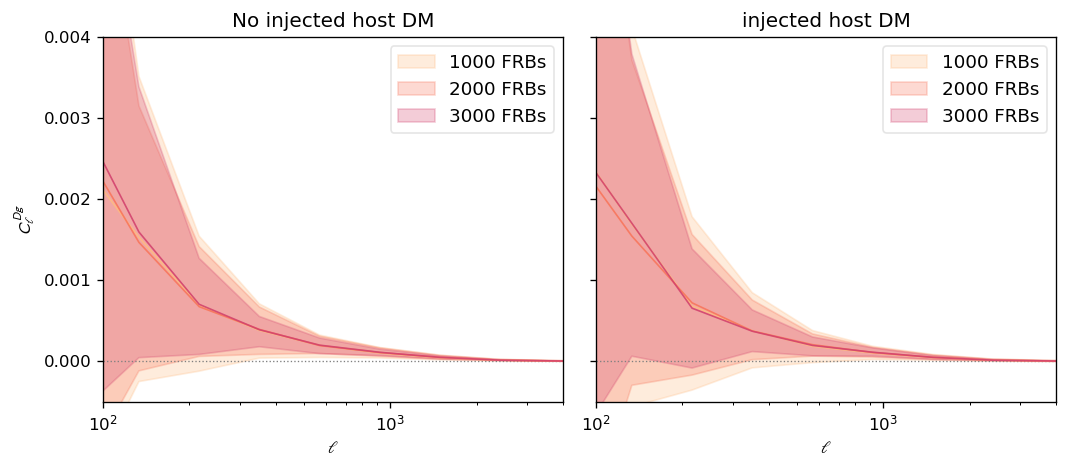

In [19]:
_ = generate_plots((res['n_frbs_sfrweight'], res['n_frbs_injhostDM']), 
                   titles=('No injected host DM', 'injected host DM'), colors=magma[:3]+magma[4:],
                   whichkeys=(1000, 2000, 3000), ref_ClDg=None, labels=lambda x: f'{x} FRBs',
                   plotinterval=True)
plt.savefig(os.path.join(figpath, 'n_frbs_inj_hostDM.pdf'))

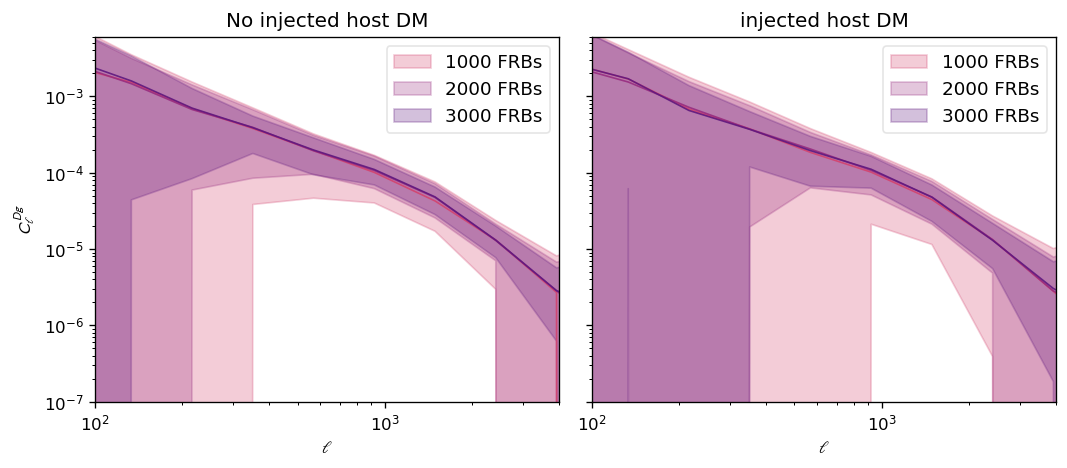

In [20]:
_ = generate_plots((res['n_frbs_sfrweight'], res['n_frbs_injhostDM']), 
                   titles=('No injected host DM', 'injected host DM'), colors=magma[2:],
                   whichkeys=(1000, 2000, 3000), ref_ClDg=None, labels=lambda x: f'{x} FRBs',
                   plotinterval=True, yscale='log')
plt.savefig(os.path.join(figpath, 'n_frbs_inj_hostDM_logscale.pdf'))

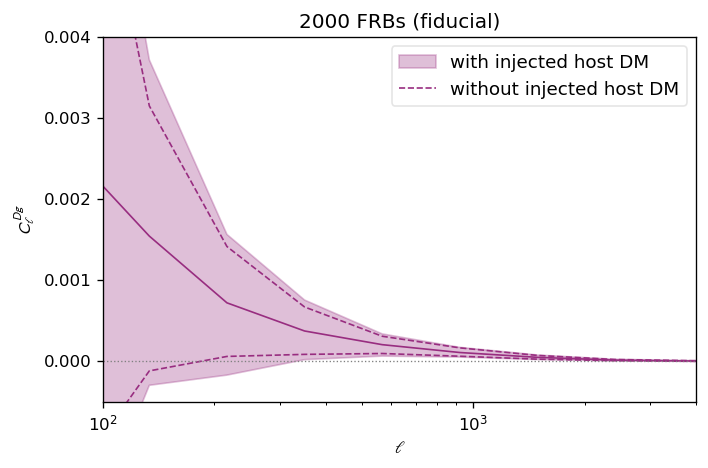

In [21]:
fig, ax = plt.subplots()

ax.set_title(f'2000 FRBs (fiducial)')
plot_xcorr_trials(ells, res['n_frbs_injhostDM'][n_frbs], ax=ax, color=magma[3], label='with injected host DM') # with and without offset is the same
plot_ref_ClDg(ax, fid_ClDgs, 0, 1, label='without injected host DM')
ax.axhline(0, color='gray', ls='dotted', lw=0.8)
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(figpath, 'fid_inj_hostDM.pdf'))

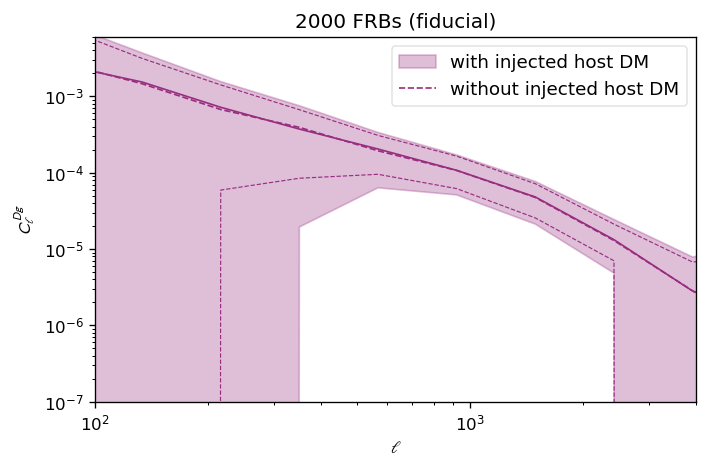

In [22]:
fig, ax = plt.subplots()

ax.set_title(f'2000 FRBs (fiducial)')
plot_xcorr_trials(ells, res['n_frbs_injhostDM'][n_frbs], ax=ax, color=magma[3], label='with injected host DM', yscale='log') # with and without offset is the same
plot_ref_ClDg(ax, fid_ClDgs, 1, 0.7, label='without injected host DM')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(figpath, 'fid_inj_hostDM_logscale.pdf'))

### projected positions

We compare the cross-correlation power spectrum from
- FRBs put uniformly (one FRB in every pixel) at the middle of the redshift slice
- The same FRBs, but we keep only the FRBs in the pixel positions of the $n = 3000$ FRBs drawn from the fiducial setup below
- FRBs put in host galaxies, weighted by star formation (fiducial)

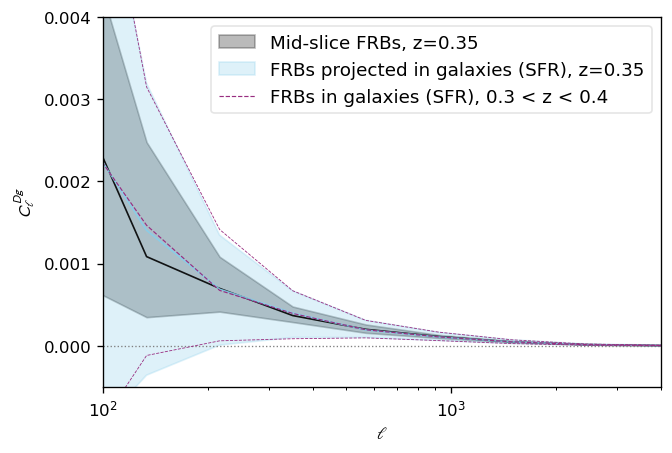

In [23]:
fig, ax = plt.subplots()
subplot_from_list((midslice_ClDgs, res['proj_sfrweight_ClDgs']), colors=('k', 'skyblue'), ax=ax,
                  labels=(f'Mid-slice FRBs, z={frb_mean_z:.2f}', f'FRBs projected in galaxies (SFR), z={frb_mean_z:.2f}'))
plot_ref_ClDg(ax, fid_ClDgs, label=f'FRBs in galaxies (SFR), {frb_zrange[0]:.1f} < z < {frb_zrange[1]:.1f}')
ax.legend()

plt.savefig(os.path.join(figpath, 'proj_FRBs.pdf'))

It is the spatial positioning of the host galaxies that dominates the difference between the mid-slice power spectrum and fiducial power spectrum. (We're missing the host DM effect though.)

## DM-dependent selection effects

### selection function

We test the effect of DM-dependent selection effects on the power spectrum. We use a log-normal distribution, which is roughly taken from Figure 16 of the [CHIME/FRB Catalog 1 paper](https://arxiv.org/pdf/2106.04352). $a=1$ roughly traces $P(\text{DM})$ given in the paper, while $a=2$ roughly scales this distribution to the redshift range of this mock catalog, which is smaller than the CHIME/FRB catalog. Higher values of $a$ skew the selection function towards lower DM values.

In [24]:
def sfunc(DMs, a=1): # fiducial selection function
    # a is how many factors to squish the selection function
    return np.exp( -(2/3)*(np.log10(DMs*a)-3)**2 )

chime_dms = pd.read_csv('/home/submit/aqc/frb_project/data/chime_data/chimefrbcat1.csv')['dm_fitb']

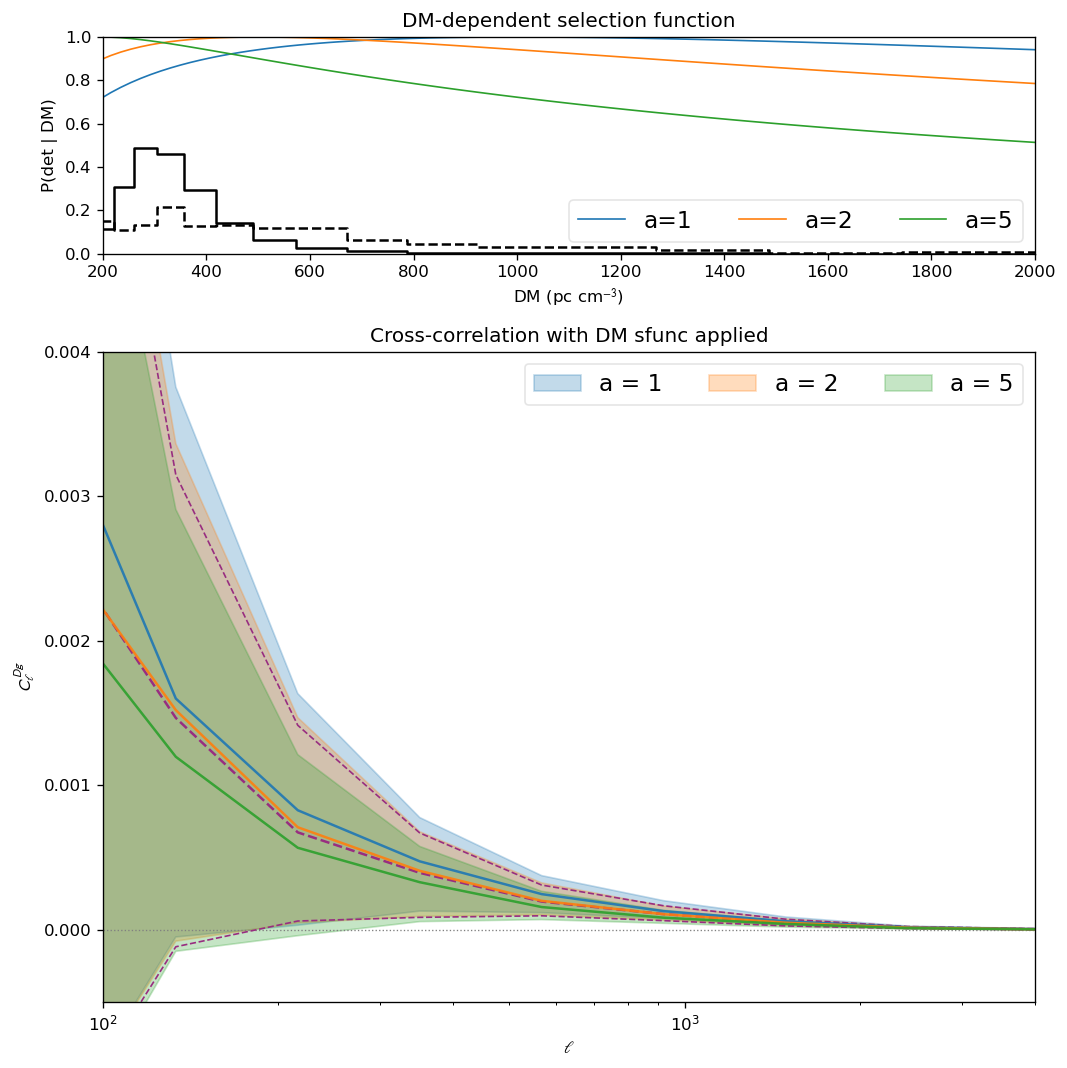

In [25]:
gs = GridSpec(2, 1, height_ratios=[1, 3])
fig = plt.figure(figsize=(9,9))

ax_s = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

# upper plot that shows DM sfunc
DM_sfunc_res = res['DM_sfunc']
for i, a in enumerate(DM_sfunc_res.keys()):
    ax_s.plot(np.linspace(100, 2000, 100), sfunc(np.linspace(100, 2000, 100), a=a), color=colorcycle[i], lw=1, label=f'a={a}')
ax_s.set_title('DM-dependent selection function')
ax_s.set_xlabel('DM (pc ' + r'cm$^{-3}$)')
ax_s.set_ylabel('P(det | DM)')
ax_s.set_ylim(0,1)
ax_s.set_xlim(200, 2000)
ax_s.legend(fontsize=14, ncol=4, loc='lower right')
bins = np.logspace(2, 4, 30)
H, _= np.histogram(sfr_DMs.flatten(), bins=bins, density=True)
H_chime, _ = np.histogram(chime_dms, bins=bins, density=True)
ax_s.step(bins[1:], 100*H, 'k', bins[1:], 100*H_chime, 'k--', where='pre')

# plot cross correlation
subplot_from_dict(DM_sfunc_res, ref_ClDg=fid_ClDgs, ref_lws=(1.5, 1), ref_label=None, colors=colorcycle,
                 labels=lambda x: f'a = {x}', ax=ax, legend=False, lw=1.5, yscale='linear')
ax.legend(fontsize=14, ncol=4, loc='upper right')
ax.set_title('Cross-correlation with DM sfunc applied')
# ax.set_xlim(200, 4000)
# ax.set_ylim(-0.001, 0.006)

plt.tight_layout()

plt.savefig(os.path.join(figpath, 'DM_sfunc.pdf'))

The top plot shows the DM-dependent selection function, as well as the (arbitrary norm) DM distributions of z=0.35 simulated FRBs (solid) and CHIME Catalog 1 FRBs (dashed). The bottom plot shows the cross-power spectrum of the DM-dependent selection function on the fiducial setup. Realistic DM-dependent selection effects do not significantly affect the power spectrum. $a=1$ pulls the power spectrum slightly higher as it favors higher DM values, and vice versa for $a=5$.

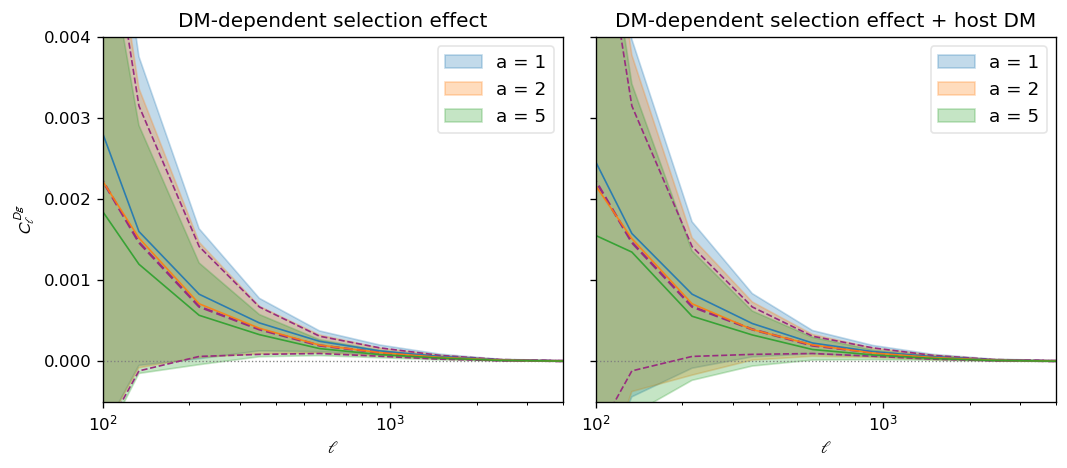

In [26]:
_ = generate_plots((res['DM_sfunc'], res['DM_sfunc_injhostDM']), 
                   titles=('DM-dependent selection effect', 'DM-dependent selection effect + host DM'), 
                   ref_ClDg=fid_ClDgs, ref_lws=(1.5, 1), ref_label=None,
                   labels=lambda x: f'a = {x}')
plt.tight_layout()
# plt.savefig(os.path.join(figpath, 'DMsfunc_injhostDM.pdf'))

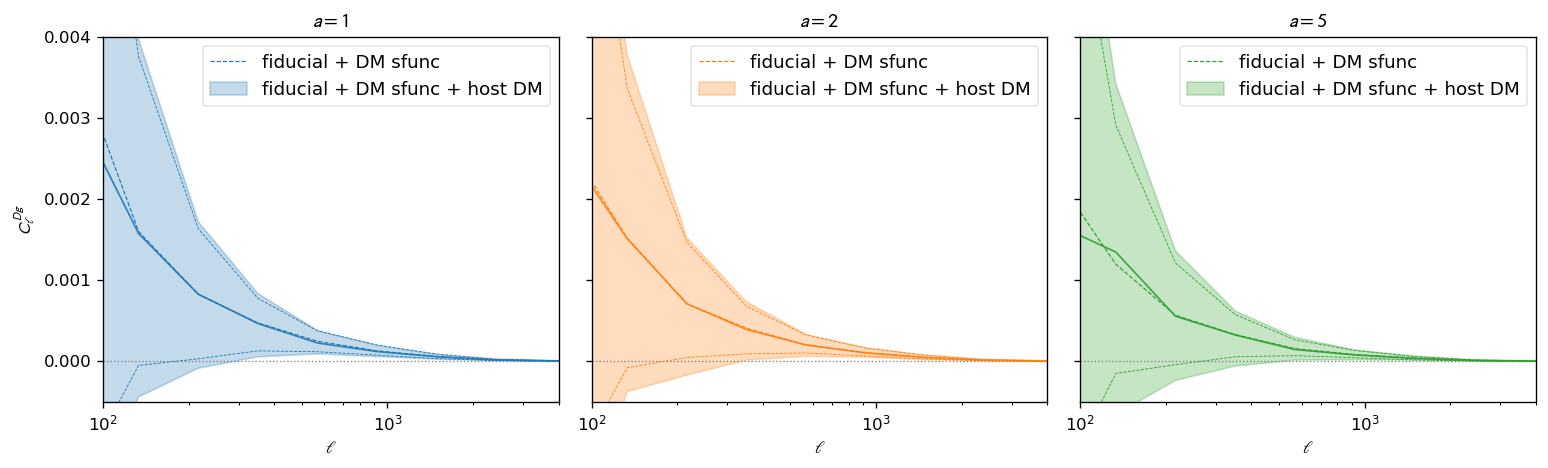

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(13,4), sharex=True, sharey=True)

a_list = (1,2,5)
for i, ax in enumerate(axes):
    # plot_ref_ClDg(ax, fid_ClDgs, label=f'fiducial')
    plot_ref_ClDg(ax, res['DM_sfunc'][a_list[i]], label=f'fiducial + DM sfunc', color=colorcycle[i])
    _ = subplot_from_list((res['DM_sfunc_injhostDM'][a_list[i]],), colors=(colorcycle[i],), ax=ax,
                           labels=('fiducial + DM sfunc + host DM',))
    if i > 0:
        ax.set_ylabel('')
    ax.set_title(f'$a = {a_list[i]}$')
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(figpath, 'DMsfunc_injhostDM.pdf'))

### DM cutoff

We test the effect of hard DM cuts (i.e. removing FRBs with DM over the cutoff value).

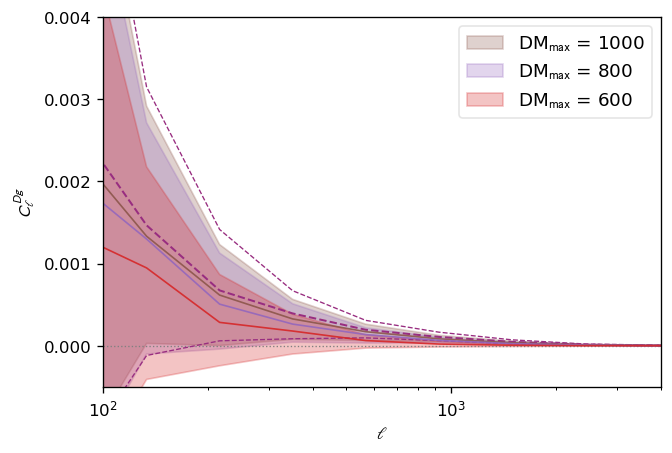

In [28]:
subplot_from_dict(res['DM_cutoffs'], whichkeys=(1000, 800, 600), ref_ClDg=fid_ClDgs, ref_label=None, 
                  labels=lambda x: r'DM$_\text{max}$ = '+str(x), yscale='linear', colors=colorcycle[5::-1])
plt.savefig(os.path.join(figpath, 'DMcutoffs.pdf'))

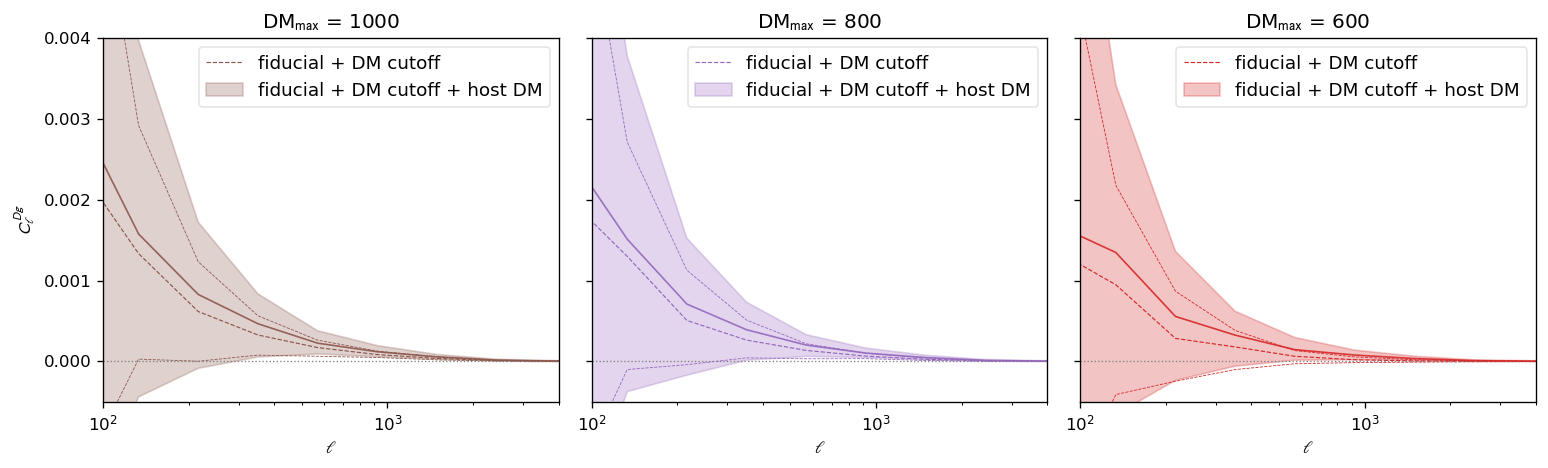

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(13,4), sharex=True, sharey=True)

cutoffs = (1000, 800, 600)
for i, ax in enumerate(axes):
    # plot_ref_ClDg(ax, fid_ClDgs, label=f'fiducial')
    plot_ref_ClDg(ax, res['DM_cutoffs'][cutoffs[i]], label=f'fiducial + DM cutoff', color=colorcycle[5-i])
    _ = subplot_from_list((res['DM_sfunc_injhostDM'][a_list[i]],), colors=(colorcycle[5-i],), ax=ax,
                           labels=('fiducial + DM cutoff + host DM',))
    if i > 0:
        ax.set_ylabel('')
    ax.set_title(r'DM$_\text{max}$ = '+str(cutoffs[i]))
    ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(figpath, 'DMcutoffs_injhostDM.pdf'))

## apparent magnitude cutoffs

We cross-correlate with a galaxy catalog with an apparent magnitude cutoff.

In [30]:
res['m_g_cutoffs'].keys()

dict_keys([25.4, 20.7])

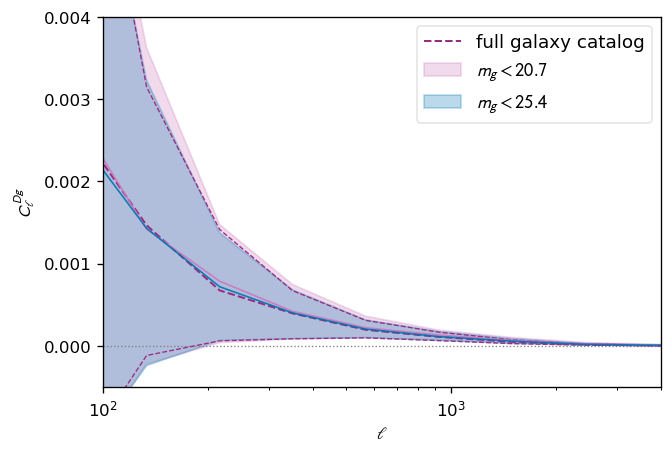

In [31]:
subplot_from_dict(res['m_g_cutoffs'], whichkeys=(20.7, 25.4), labels=lambda x: f'$m_g < {x}$', colors=[colorblind[4], colorblind[0]],
                  ref_ClDg=fid_ClDgs, ref_label='full galaxy catalog', yscale='linear')
plt.savefig(os.path.join(figpath, 'm_g_cutoffs.pdf'))

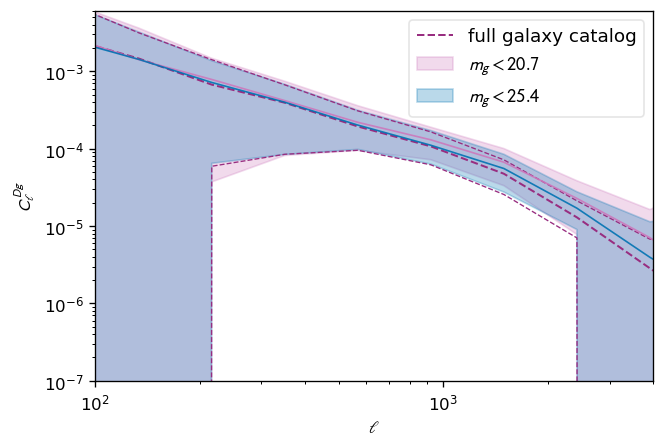

In [32]:
subplot_from_dict(res['m_g_cutoffs'], whichkeys=(20.7, 25.4), labels=lambda x: f'$m_g < {x}$', colors=[colorblind[4], colorblind[0]],
                  ref_ClDg=fid_ClDgs, ref_label='full galaxy catalog', yscale='log')
plt.savefig(os.path.join(figpath, 'm_g_cutoffs_logscale.pdf'))

Using a catalog that ignores the dim galaxies biases the cross-correlation towards higher values, because galaxy map becomes "less fuzzy". Although -- what even is a galaxy, and is it the same as Illustris's criterion for what a galaxy is? -- UPDATE

In [ ]:
# plot % in catalog vs redshift
zs, m_gs = [], []
for regname in regions.keys():
    sim = exp_simulation(500 * np.array([50, 70, 23]), regname)
    g_df = sim.read_shell_galaxies()
    zs.append(np.array(sim.z_from_dist(g_df['x'])))
    m_gs.append(np.array(g_df['m_g']))

zs = np.concatenate(zs)
m_gs = np.concatenate(m_gs)

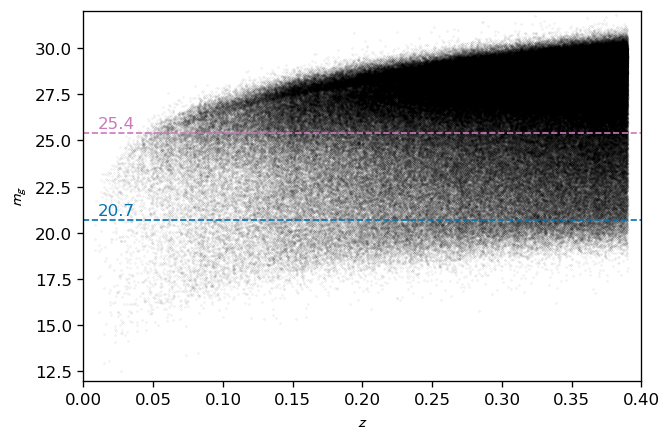

In [ ]:
#m_g vs z

randints = np.random.choice(len(zs), int(len(zs)//100)) # downsample
plt.scatter(zs[randints], m_gs[randints], s=0.1, color='k', alpha=0.1)

for color, m_g_cutoff in zip([colorblind[4], colorblind[0]], res['m_g_cutoffs'].keys()):
    plt.axhline(m_g_cutoff, color=color, lw=1, ls='--')
    plt.text(0.01, m_g_cutoff+0.1, str(m_g_cutoff), color=color, ha='left', va='bottom')

plt.xlabel('$z$')
plt.ylabel(r'$m_g$')
plt.xlim(0, 0.4)
plt.ylim(12, 32)

plt.savefig(os.path.join(figpath, 'm_g_vs_z.pdf'))

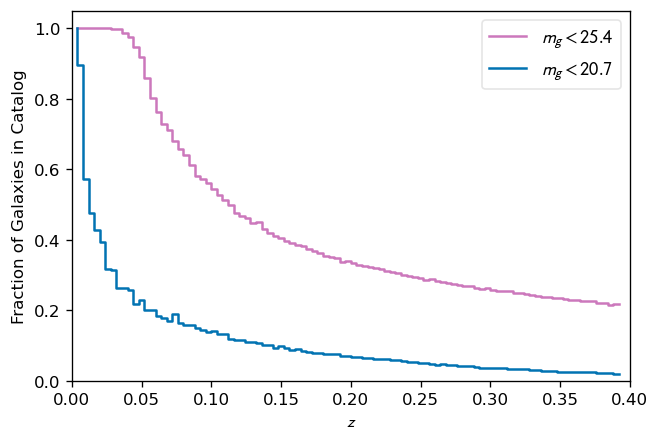

In [ ]:
zbins = np.linspace(0, 0.4, 101)
fig, ax = plt.subplots()

randints = np.random.choice(len(zs), int(len(zs)//10)) # downsample
for color, m_g_cutoff in zip([colorblind[4], colorblind[0]], res['m_g_cutoffs'].keys()):
    H, _, _ = binned_statistic(zs[randints], m_gs[randints], statistic=lambda x: len(x[x < m_g_cutoff])/len(x), bins=zbins)
    ax.step(zbins[1:-1], H[:-1], where='pre', color=color, label = r'$m_g < {}$'.format(m_g_cutoff))

ax.legend()
ax.set_xlabel('$z$')
ax.set_ylabel('Fraction of Galaxies in Catalog')
ax.set_xlim(0, 0.4)
ax.set_ylim(bottom=0)

plt.savefig(os.path.join(figpath, 'frac_g_vs_z.pdf'))

## Scattering (impact parameter) selection effects

We test the effect of scattering selection effects. For each host galaxy, we calculate the impact parameter $b$ to each intervening galaxy from $0.25x$ to $0.75x$, where $x$ is the mean comoving distance of the FRBs. The probability of scattering is modelled as
$$P(b) = 2^{-\left(\frac{b}{8\,\text{kpc}}\right)^2} $$
$$1 - P_\text{scatter} = \prod_{\text{foreground}} (1 - P(b)) $$

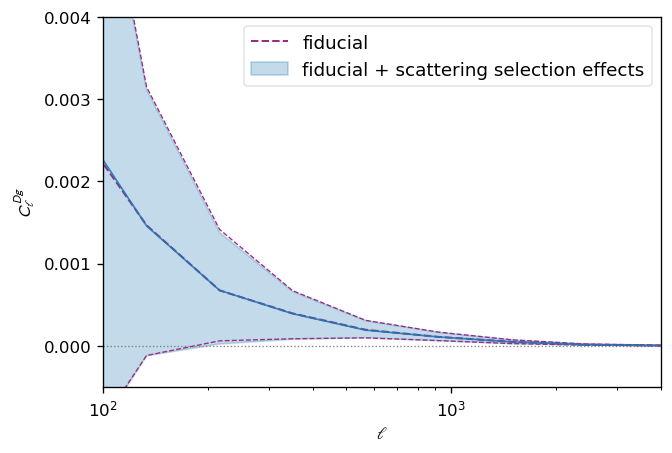

In [33]:
subplot_from_list((res['scatter_ClDgs'],), ref_ClDg=fid_ClDgs, ref_label='fiducial', labels=('fiducial + scattering selection effects',))
plt.savefig(os.path.join(figpath, 'scatter_sfunc.pdf'))

In [34]:
scatterPs = 1 - np.concatenate(res['host_properties']['scatterPs'])
cred_interval_68 = (np.percentile(scatterPs, 16), np.percentile(scatterPs, 84))

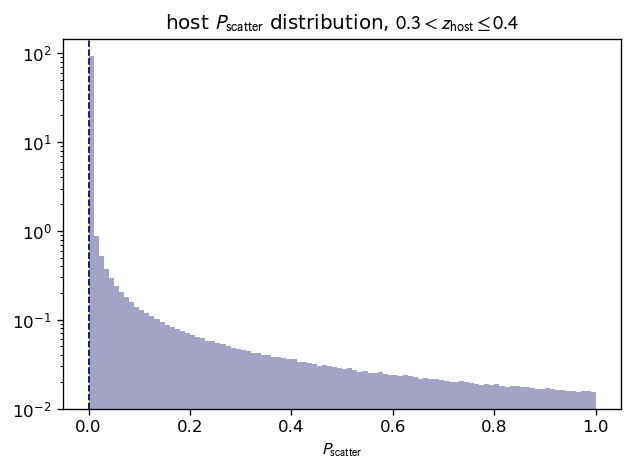

In [35]:
c = 'midnightblue'
_ = plt.hist(scatterPs, bins=100, log=True, density=True, color=c, alpha=0.4)
plt.axvline(cred_interval_68[0], color=c, ls='--', lw=1)
plt.axvline(cred_interval_68[1], color=c, ls='--', lw=1)
plt.xlabel(r'$P_\text{scatter}$')
plt.title(r'host $P_\text{scatter}$ distribution, $0.3 < z_\text{host} \leq 0.4$')
plt.savefig(os.path.join(figpath, 'host_scatter_p.pdf'))

## effect of redshift overlaps between FRBs and foreground galaxies

### varying the galaxy redshift range

In a realistic FRB catalog, we will have unknown or imprecise redshift measurements for FRBs, making a partial overlap between the redshift ranges of FRBs and foreground galaxies likely. We probe the effect of this overlap. Here, we vary the redshift range of the foreground galaxy catalog, cross-correlating with FRBs in the full redshift range ($0 < z < 0.4$, placed in galaxies weighted by SFR).

The signal gets boosted as we approach $0 < z_g < 0.4$, since at that point both datasets are drawn from the same pool of galaxies. The median cross-correlation surprisingly stays the same. I would expect it to be biased towards a greater cross-correlation, but only the variance increases.

### varying the FRB redshift range

Here, we instead vary the redshift range of the FRBs, keeping $0.2 < z_g < 0.3$.

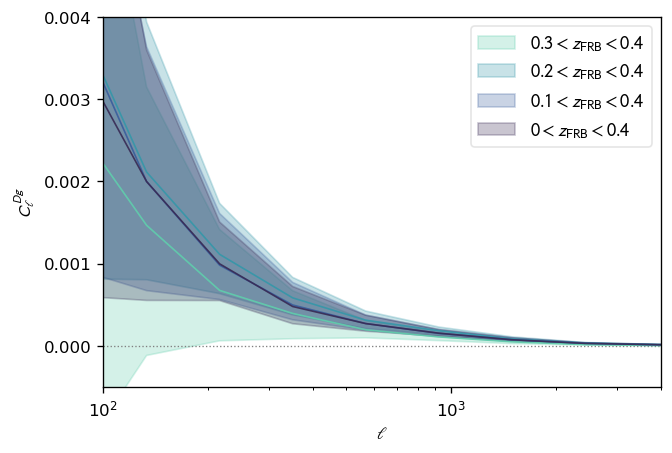

In [36]:
fig, ax = plt.subplots()
subplot_from_dict(res['overlap_frb_zranges'], 
                  labels=lambda x: f'${x[0]} < ' + r'z_\text{FRB}' + f' < {x[1]}$', 
                  colors=mako, ax=ax)
ax.legend()

plt.savefig(os.path.join(figpath, 'frb_overlap.pdf'))

The overlap boosts the signal a lot! The bigger the fraction of FRBs that overlap with the galaxy range, the more the signal gets boosted.

# combined experiment

Finally, we test the combined effects of all investigated astrophysical and observational selection effects: we use the fiducial setup (drawing FRBs from galaxies weighted by SFR, $0.3 < z_\text{host} \leq 0.4$, $0.2 < z_g \leq 0.3$), inject a host DM, add DM-dependent selection effects and scattering selection effects, and cross-correlate with a galaxy catalog with an apparent magnitude cutoff.

In [9]:
# load in results

combined_res_path = '/ceph/submit/data/group/submit-illustris/april/data/C_ells/combined_experiment.pkl'
with open(combined_res_path, 'rb') as f:
    combined_res = pickle.load(f)
print(list(combined_res.keys()))

midslice_ClDgs = combined_res['midslice']['ClDgs']

['regions', 'slice_exp', 'full_exp', 'midslice', 'full', 'l']


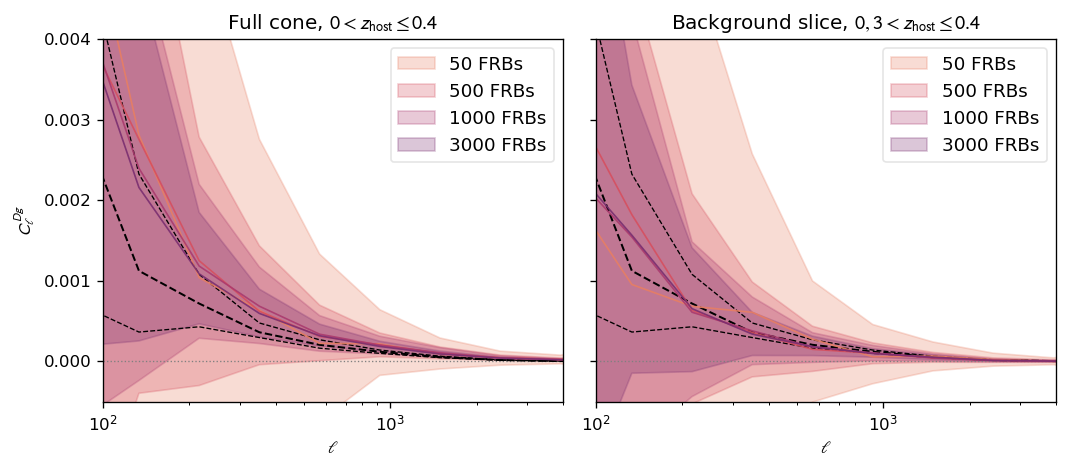

In [25]:
_ = generate_plots((combined_res['full_exp']['ClDgs_exp'], combined_res['slice_exp']['ClDgs_exp']), 
                   titles=(r'Full cone, $0 < z_\text{host} \leq 0.4$', r'Background slice, $0,3 < z_\text{host} \leq 0.4$'),
                   whichkeys=(50, 500, 1000, 3000), ref_ClDg=midslice_ClDgs, ref_label=None, labels=lambda x: f'{x} FRBs',
                   plotinterval=True, colors=flare)
plt.savefig(os.path.join(figpath, 'combined_slice_vs_full.pdf'))

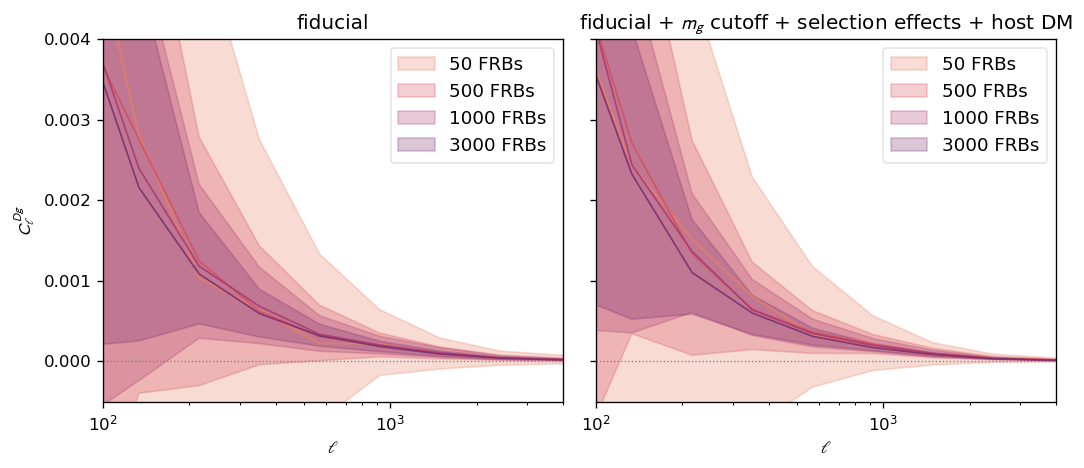

In [12]:
subdict = combined_res['full_exp'] # full cone, 0 < z < 0.4

_ = generate_plots((subdict['ClDgs_exp'],subdict['ClDgs']), 
                   titles=('fiducial', 'fiducial + $m_g$ cutoff + selection effects + host DM'),
                   whichkeys=(50, 500, 1000, 3000), ref_ClDg=None, ref_label=None, labels=lambda x: f'{x} FRBs',
                   plotinterval=True, colors=flare)

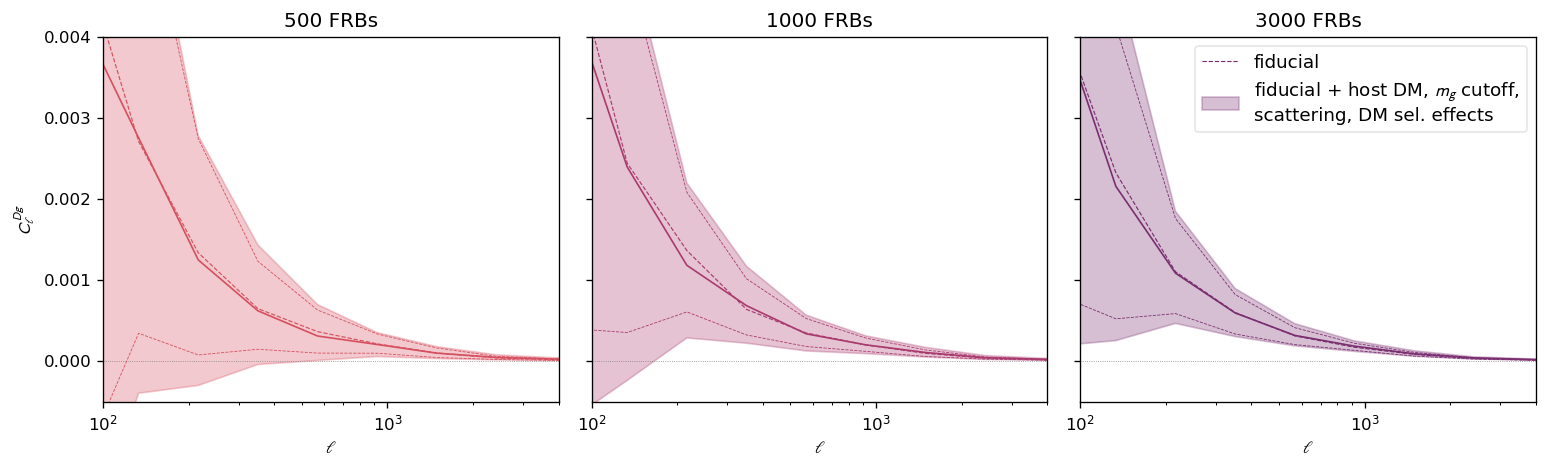

In [30]:
subdict = combined_res['full_exp']

fig, axes = plt.subplots(1, 3, figsize=(13,4), sharex=True, sharey=True)

n_frbs_ = (500, 1000, 3000)
for i, ax in enumerate(axes):
    n_frb_ = n_frbs_[i]
    plot_ref_ClDg(ax, subdict['ClDgs'][n_frb_], color=flare[i+1], label='fiducial')
    plot_xcorr_trials(ells, subdict['ClDgs_exp'][n_frb_], color=flare[i+1], ax=ax, label='fiducial + host DM, $m_g$ cutoff,\nscattering, DM sel. effects')
    ax.axhline(0, color='gray', ls='dotted', lw=0.5)
    if i > 0:
        ax.set_ylabel('')
    ax.set_title(f'{n_frb_} FRBs')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(figpath, 'combined_fullcone_effects.pdf'))

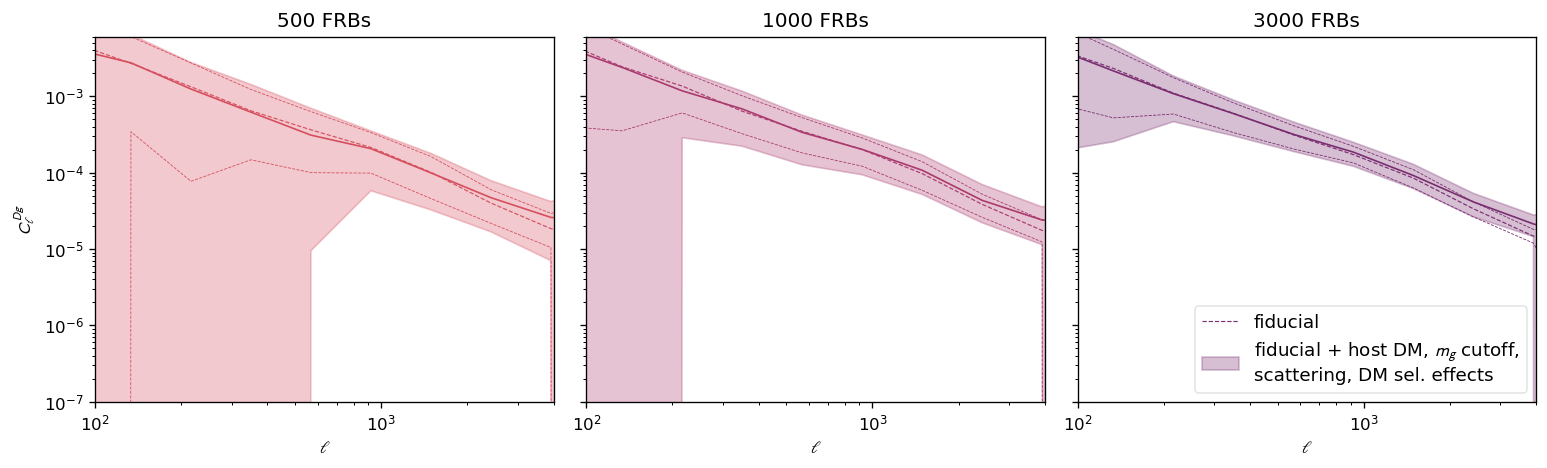

In [31]:
subdict = combined_res['full_exp']

fig, axes = plt.subplots(1, 3, figsize=(13,4), sharex=True, sharey=True)

n_frbs_ = (500, 1000, 3000)
for i, ax in enumerate(axes):
    n_frb_ = n_frbs_[i]
    plot_ref_ClDg(ax, subdict['ClDgs'][n_frb_], color=flare[i+1], label='fiducial')
    plot_xcorr_trials(ells, subdict['ClDgs_exp'][n_frb_], color=flare[i+1], ax=ax, yscale='log',
                      label='fiducial + host DM, $m_g$ cutoff,\nscattering, DM sel. effects')
    if i > 0:
        ax.set_ylabel('')
    ax.set_title(f'{n_frb_} FRBs')
axes[2].legend(loc='lower right')

plt.tight_layout()
plt.savefig(os.path.join(figpath, 'combined_fullcone_effects_log.pdf'))

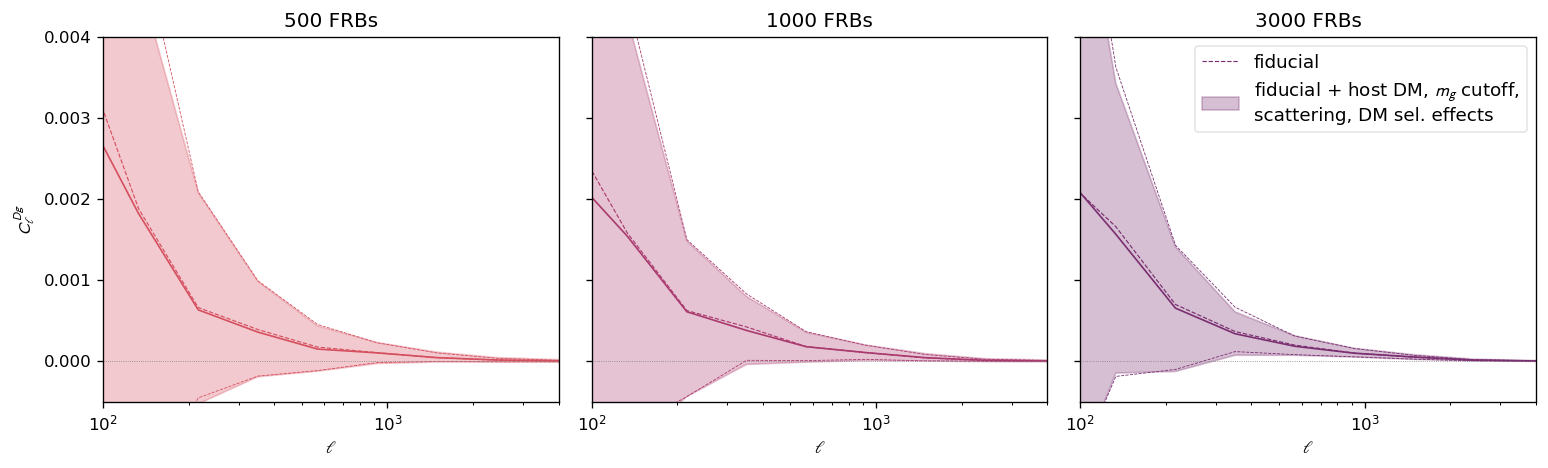

In [27]:
subdict = combined_res['slice_exp']

fig, axes = plt.subplots(1, 3, figsize=(13,4), sharex=True, sharey=True)

n_frbs_ = (500, 1000, 3000)
for i, ax in enumerate(axes):
    n_frb_ = n_frbs_[i]
    plot_ref_ClDg(ax, subdict['ClDgs'][n_frb_], color=flare[i+1], label='fiducial')
    plot_xcorr_trials(ells, subdict['ClDgs_exp'][n_frb_], color=flare[i+1], ax=ax, label='fiducial + host DM, $m_g$ cutoff,\nscattering, DM sel. effects')
    ax.axhline(0, color='gray', ls='dotted', lw=0.5)
    if i > 0:
        ax.set_ylabel('')
    ax.set_title(f'{n_frb_} FRBs')
axes[2].legend()

plt.tight_layout()
plt.savefig(os.path.join(figpath, 'combined_slice_effects.pdf'))